<a href="https://colab.research.google.com/github/AbdulmagedALKHULAIFI/Automatic-classifer-consumer-goods/blob/main/p6_1_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Contexte

L'objectif de ce projet est d'aider l’entreprise "Place de marché” dans l'amélioration de l'expérience des utilisateurs de leur plateforme et rend plus fluide et agréable. Commençant par l'automatisation de la catégorisation des articles chargés par les vendeurs.

## Missions

Les missions qui me sont confiées ce sont: 



*    réaliser une première étude de faisabilité d'un moteur de classification en se basant sur l'image et la description de produit
*   Prétaiter le jeu de données 
*   Réduire les dimension de jeu de données
*   Regrouper les produits ayant des carateristiques simlaires





# Installation

In [144]:
!pip install -U gensim

In [145]:
!pip install yellowbrick

In [146]:
!pip install tensorflow

  Using cached numpy-1.19.5-cp37-cp37m-manylinux2010_x86_64.whl (14.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.0
    Uninstalling numpy-1.20.0:
      Successfully uninstalled numpy-1.20.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [147]:
pip install tensorflow-text

In [148]:
# pip uninstall numpy


In [149]:
pip install numpy==1.20.0

  Using cached numpy-1.20.0-cp37-cp37m-manylinux2010_x86_64.whl (15.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires numpy~=1.19.2, but you have numpy 1.20.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


# To-do list

- corriger l'affichage des mots le plus communs dans un cluster
- Envistiguer sur le bag of words
- integré la partie supervisé USE

# Import

In [150]:
# import libraries
import numpy as np 
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import GridSearchCV
from nltk.stem.wordnet import WordNetLemmatizer
import sklearn.metrics as metrics
from sklearn.decomposition import PCA
from sklearn import decomposition
import seaborn as sns
import matplotlib.pyplot as plt
from nltk import ngrams
from nltk import bigrams
from nltk import trigrams
import  collections
from sklearn.metrics import silhouette_score,silhouette_samples
import matplotlib.cm as cm
from sklearn.feature_extraction.text import TfidfVectorizer

from yellowbrick.text import TSNEVisualizer
from yellowbrick.datasets import load_hobbies

import numpy as np 
from pandas import DataFrame
import seaborn as sns
%matplotlib inline

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics.cluster import adjusted_rand_score

In [151]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [152]:
data = pd.read_csv("./flipkart_com-ecommerce_sample_1050.csv")
data.head(3)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."


Le jeu de données est composé de deux partie:

* Jeu de données de produits de site sous format CSV
* Un répertoire contenant les images de produits

In [153]:
data.describe()

,retail_price,discounted_price
count,1049.000000,1049.000000
mean,2186.197331,1584.527169
std,7639.229411,7475.099680
min,35.000000,35.000000
25%,555.000000,340.000000
50%,999.000000,600.000000
75%,1999.000000,1199.000000
max,201000.000000,201000.000000


In [154]:
corpus = data[['description']]
corpus.head(3)

,description
0,Key Features of Elegance Polyester Multicolor ...
1,Specifications of Sathiyas Cotton Bath Towel (...
2,Key Features of Eurospa Cotton Terry Face Towe...


In [155]:
corpus.shape

(1050, 1)

#  Récupération des catégories principales

In [156]:
data['main_cat'] = data.product_category_tree.str.split(">>",expand=True,)[0]
data.head(3)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,main_cat
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...","[""Home Furnishing"
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...","[""Baby Care"
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...","[""Baby Care"


In [157]:
data['main_cat'] = data['main_cat'].str.replace(r'"', '')
data['main_cat'] = data['main_cat'].str.replace(r'[', '')
data['main_cat'] = data['main_cat'].str.replace(r']', '')

In [158]:
data['main_cat'].unique()

array(['Home Furnishing ', 'Baby Care ', 'Watches ',
       'Home Decor & Festive Needs ', 'Kitchen & Dining ',
       'Beauty and Personal Care ', 'Computers '], dtype=object)

# Data preprocessing

In [159]:
dataMini = data[['main_cat','description']]
dataMini

,main_cat,description
0,Home Furnishing,Key Features of Elegance Polyester Multicolor ...
1,Baby Care,Specifications of Sathiyas Cotton Bath Towel (...
2,Baby Care,Key Features of Eurospa Cotton Terry Face Towe...
3,Home Furnishing,Key Features of SANTOSH ROYAL FASHION Cotton P...
4,Home Furnishing,Key Features of Jaipur Print Cotton Floral Kin...
...,...,...
1045,Baby Care,Oren Empower Extra Large Self Adhesive Sticker...
1046,Baby Care,Wallmantra Large Vinyl Sticker Sticker (Pack o...
1047,Baby Care,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...
1048,Baby Care,Buy Wallmantra Medium Vinyl Sticker Sticker fo...


In [160]:
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [161]:
lst_stopwords = nltk.corpus.stopwords.words("english")

In [162]:
dataMini["text_clean"] = dataMini["description"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))
dataMini.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,main_cat,description,text_clean
0,Home Furnishing,Key Features of Elegance Polyester Multicolor ...,key feature elegance polyester multicolor abst...
1,Baby Care,Specifications of Sathiyas Cotton Bath Towel (...,specification sathiyas cotton bath towel 3 bat...
2,Baby Care,Key Features of Eurospa Cotton Terry Face Towe...,key feature eurospa cotton terry face towel se...
3,Home Furnishing,Key Features of SANTOSH ROYAL FASHION Cotton P...,key feature santosh royal fashion cotton print...
4,Home Furnishing,Key Features of Jaipur Print Cotton Floral Kin...,key feature jaipur print cotton floral king si...


Créer une list de texte nettoyé pour entrainer les modèles non-supervisé

In [163]:
clean_desc = []
for w in range(len(dataMini.text_clean)):
    clean_desc.append(dataMini.text_clean.iloc[w])

In [164]:
clean_desc[:3]

['key feature elegance polyester multicolor abstract eyelet door curtain floral curtainelegance polyester multicolor abstract eyelet door curtain 213 cm height pack 2 price r 899 curtain enhances look interiorsthis curtain made 100 high quality polyester fabricit feature eyelet style stitch metal ringit make room environment romantic lovingthis curtain ant wrinkle anti shrinkage elegant apparancegive home bright modernistic appeal design surreal attention sure steal heart contemporary eyelet valance curtain slide smoothly draw apart first thing morning welcome bright sun ray want wish good morning whole world draw close evening create special moment joyous beauty given soothing print bring home elegant curtain softly filter light room get right amount sunlightspecifications elegance polyester multicolor abstract eyelet door curtain 213 cm height pack 2 general brand elegance designed door type eyelet model name abstract polyester door curtain set 2 model id duster25 color multicolor di

Ici, nous convertirons les catégories des produits de format text en format numérique pour que Bert puisse l'utiliser

In [165]:
dataMini.sample(10)

,main_cat,description,text_clean
876,Home Furnishing,Buy Textile India Paisley Double Quilts & Comf...,buy textile india paisley double quilt comfort...
547,Watches,Maxima 01727LPLN Mac Gold Analog Watch - For ...,maximum 01727lpln mac gold analog watch woman ...
532,Watches,HMT HMTWHQ Analog Watch - For Men - Buy HMT H...,hmt hmtwhq analog watch men buy hmt hmtwhq ana...
991,Kitchen & Dining,Seven Seas Stainless Steel Twisting Pull Corks...,seven sea stainless steel twisting pull corksc...
69,Kitchen & Dining,Specifications of GAYATRI CREATIONS ORANGE KID...,specification gayatri creation orange kid set ...
655,Baby Care,Buy Wood Beauty Wood Photo Frame for Rs.450 on...,buy wood beauty wood photo frame rs450 online ...
921,Home Decor & Festive Needs,"Buy Digilight 400 inch White, Blue Rice Lights...",buy digilight 400 inch white blue rice light r...
1011,Baby Care,Specifications of SJ Tulip multi use cotton Ba...,specification sj tulip multi use cotton ball p...
172,Kitchen & Dining,Rockmantra Abstrcts 8 Ceramic Mug (5.5 l)\r\n ...,rockmantra abstrcts 8 ceramic mug 55 l price r...
214,Home Decor & Festive Needs,Shoppingtara Paper Mache 3 Piece Elephant Home...,shoppingtara paper mache 3 piece elephant home...


## Division de jeu de données

Nous allons diviser le jeu de données en deux parties(train et test) pour entraîner les modèles machine learning supervisés

In [166]:
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
from sklearn.model_selection import train_test_split

## split dataset
dtf_train, dtf_test = model_selection.train_test_split(dataMini, test_size=0.2)

# X_train, X_test, y_train, y_test = train_test_split(dataMini['description'],dataMini['main_cat_num'], test_size=0.2)

# get target
y_train = dtf_train["main_cat"].values
y_test = dtf_test["main_cat"].values

# N-gram

N-gramme est une sous-séquence de n éléments construite à partir d'une séquence donnée. L'idée est que, à partir d'une séquence de mots donnée. il est possible d'obtenir la fonction de vraisemblance de l'apparition de mot suivant.

In [167]:
# generate unigrams bigrams trigrams

unigram=[]
bigram=[]
trigram=[]
tokenized_text=[]

for sentence in dataMini['text_clean']:
    unigram.extend(unigram)
    bigram.extend(bigrams(sentence.split(' ')))
    trigram.extend(trigrams(sentence.split(' ')))

In [168]:
bigramFreq = collections.Counter(bigram)
bigramFreq

Counter({('key', 'feature'): 207,
         ('feature', 'elegance'): 1,
         ('elegance', 'polyester'): 2,
         ('polyester', 'multicolor'): 4,
         ('multicolor', 'abstract'): 3,
         ('abstract', 'eyelet'): 4,
         ('eyelet', 'door'): 14,
         ('door', 'curtain'): 26,
         ('curtain', 'floral'): 1,
         ('floral', 'curtainelegance'): 1,
         ('curtainelegance', 'polyester'): 1,
         ('curtain', '213'): 4,
         ('213', 'cm'): 9,
         ('cm', 'height'): 22,
         ('height', 'pack'): 12,
         ('pack', '2'): 61,
         ('2', 'price'): 15,
         ('price', 'r'): 342,
         ('r', '899'): 5,
         ('899', 'curtain'): 1,
         ('curtain', 'enhances'): 1,
         ('enhances', 'look'): 1,
         ('look', 'interiorsthis'): 1,
         ('interiorsthis', 'curtain'): 1,
         ('curtain', 'made'): 1,
         ('made', '100'): 8,
         ('100', 'high'): 2,
         ('high', 'quality'): 69,
         ('quality', 'polyester'): 3,

In [169]:
trigramFreq = collections.Counter(trigram)
trigramFreq

Counter({('key', 'feature', 'elegance'): 1,
         ('feature', 'elegance', 'polyester'): 1,
         ('elegance', 'polyester', 'multicolor'): 2,
         ('polyester', 'multicolor', 'abstract'): 3,
         ('multicolor', 'abstract', 'eyelet'): 3,
         ('abstract', 'eyelet', 'door'): 3,
         ('eyelet', 'door', 'curtain'): 14,
         ('door', 'curtain', 'floral'): 1,
         ('curtain', 'floral', 'curtainelegance'): 1,
         ('floral', 'curtainelegance', 'polyester'): 1,
         ('curtainelegance', 'polyester', 'multicolor'): 1,
         ('door', 'curtain', '213'): 4,
         ('curtain', '213', 'cm'): 4,
         ('213', 'cm', 'height'): 4,
         ('cm', 'height', 'pack'): 12,
         ('height', 'pack', '2'): 7,
         ('pack', '2', 'price'): 11,
         ('2', 'price', 'r'): 15,
         ('price', 'r', '899'): 5,
         ('r', '899', 'curtain'): 1,
         ('899', 'curtain', 'enhances'): 1,
         ('curtain', 'enhances', 'look'): 1,
         ('enhances', 'loo

# Features extraction

Les données texte ne sont pas calculables et doivent donc être transformées en données numériques comme matrices ou des vecteurs pour que les modèles machine learning pussient les utilisent.

## TF-IDF

TF-IDF(Term Frequency/Inverse Document Frequency) est l'une des techniques  les plus populaires pour analyser l'importance d'un mot dans un document.

In [170]:
tf_vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,3))

## bag of words

Le sac de mots est un modèle de représentation des données textuels, qui compte simplement combien de fois un mot apparaît dans un document.

In [171]:
## Count (classic BoW)
bow_vectorizer = feature_extraction.text.CountVectorizer(max_features=10000, ngram_range=(1,3))

## Universal sentenance encoder


In [172]:
def pca99(X):
    '''function reduce dimensions using t-SNE PCA keeping 99% of variance, returns np array and df '''
   
    print('dim before PCA : ', X.shape)
    pca = decomposition.PCA(n_components=0.99)
    X_pca = pca.fit_transform(X)
    print('dim after PCA : ', X_pca.shape)
    df_pca = pd.DataFrame(X_pca)
    return X_pca, df_pca

In [173]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-large/4'
USE_embed = hub.KerasLayer(module_url, trainable=False, name='USE_embedding')

In [174]:
# ------------------------------------------------------------------------------------

In [175]:
# X = data_raw['product_name']
#X = data['description_cleaned']
# X = dataMini['description']
#X = data['product_name_cleaned']
#X=data['product_name_cleaned'] + ' ' + data['description_cleaned']
#X=data_raw['product_name'] + ' ' + data_raw['description']
# tf_tensor = encoder(X.values)

In [176]:
# pass tensor as dataframe
# df_use = pd.DataFrame(tf.make_ndarray(tf.make_tensor_proto(tf_tensor)))

In [177]:
# pca
# X_pca_use, df_pca_use = pca99(df_use)

In [178]:
# tsne
# X_tsne_use, df_tsne_use = tsne(X_pca_use, 2)

In [179]:
# make clusters
# X = X_tsne_use
# labels_use, centers_use = get_clusters(X, 7)

In [180]:
# ------------------------------------------------------------------------------------------------

## Word2vect

In [181]:
dataMini.columns

Index(['main_cat', 'description', 'text_clean'], dtype='object')

In [182]:
# Pre-processing
tokenizer = nltk.RegexpTokenizer(r'\w+')
data['tokens']= dataMini['text_clean'].apply(lambda x : tokenizer.tokenize(x))
sentences = data['tokens']

In [183]:
sentences

0       [key, feature, elegance, polyester, multicolor...
1       [specification, sathiyas, cotton, bath, towel,...
2       [key, feature, eurospa, cotton, terry, face, t...
3       [key, feature, santosh, royal, fashion, cotton...
4       [key, feature, jaipur, print, cotton, floral, ...
                              ...                        
1045    [oren, empower, extra, large, self, adhesive, ...
1046    [wallmantra, large, vinyl, sticker, sticker, p...
1047    [buy, uberlyfe, extra, large, pigmented, polyv...
1048    [buy, wallmantra, medium, vinyl, sticker, stic...
1049    [buy, uberlyfe, large, vinyl, sticker, rs595, ...
Name: tokens, Length: 1050, dtype: object

<span style="color:red"> Dans le cas d'erreur dans l'étape suivante. Vérifiez que le numpy versuib 1.20.0 est bien installé. Si vous utilisez Google Colab. redémarrez votre notebook. </span>

In [184]:
from gensim.models import Word2Vec
from gensim.test.utils import common_texts
from time import time

In [185]:
# Set parameters
w2v_model = Word2Vec(min_count=1,
                     window=4,
                    #  size = 3000,
                   #  sample=6e-5, 
                    # alpha=0.03, 
                   #  min_alpha=0.0007, 
                    # negative=20,
                     workers= 4)

In [186]:
# Build vocabulary table
t = time()
w2v_model.build_vocab(sentences, progress_per=10000)
print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.0 mins


In [187]:
# Train mode;
t = time()
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 0.03 mins


In [188]:
# Pour chaque phrase, on fait la somme des vecteurs associés aux mots qui la composent 
# adding word vectors of  for each sentence
def get_vect(word, model):
    try:
        return model.wv[word]
    except KeyError:
        return np.zeros((model.vector_size,))

def sum_vectors(phrase, model):
    return sum(get_vect(w, model) for w in phrase)

def word2vec_features(X, model):
    feats = np.vstack([sum_vectors(p, model) for p in X])
    return feats

wv_train_feat = word2vec_features(sentences, w2v_model)
wv_train_feat.shape

(1050, 100)

In [189]:
pca99 = PCA(n_components=0.99)

In [190]:
print('dim before PCA : ', wv_train_feat.shape)
pca = decomposition.PCA(n_components=0.99)
X_pca = pca.fit_transform(wv_train_feat)
print('dim after PCA : ', X_pca.shape)
df_pca = pd.DataFrame(X_pca)
X_wv_train_feat = X_pca
df_wv_train_feat = df_pca

dim before PCA :  (1050, 100)
dim after PCA :  (1050, 21)


In [191]:
# X_wv_train_feat, df_wv_train_feat = pca99(wv_train_feat)

Nous allons créer le train et test datasets pour les autres modèles supervisé.

In [192]:
def createInput(vectorizer):
    corpus = dtf_train["text_clean"]
    vectorizer.fit(corpus)
    X_train = vectorizer.transform(corpus)
    return X_train

# Classifieurs

In [193]:
navie_bayes_classifier = naive_bayes.MultinomialNB()

In [194]:
kmeans = KMeans(n_clusters=7, init='k-means++', n_init=10, max_iter=300, random_state=0)

def cluster_kmeans(vect):

    kmeans.fit(vect)
    #this loop transforms the numbers back into words
    common_words = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]
#     for num, centroid in enumerate(common_words):
#         print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))
    # print(enumerate(common_words))
    

# Pipeline

## Modèles supervisés

In [195]:
def createPipeline(classifier,vectorizer):
    ## pipeline
    model = pipeline.Pipeline([("vectorizer", vectorizer),  
                               ("classifier", classifier)])
    ## Create X_train 
    X_train = createInput(vectorizer)
    
    ## train classifier
    model["classifier"].fit(X_train, y_train)
    
    ## test
    X_test = dtf_test["text_clean"].values
    predicted = model.predict(X_test)
    return predicted

Nous allons créer des pipeline pour tous les extracteur de features :

In [196]:
tf_predicted = createPipeline(navie_bayes_classifier,tf_vectorizer)

In [197]:
bow_predicted = createPipeline(navie_bayes_classifier,bow_vectorizer)

In [198]:
# -------------------------------------------------------------------------------------------------

In [199]:
# X_train, X_test, y_train, y_test = train_test_split(dataMini[["text_clean"]], dataMini['main_cat'])

In [200]:
# from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
# from sklearn.pipeline import make_pipeline
# pipe = make_pipeline(CountVectorizer(), TfidfTransformer())
# pipe.fit(X_train['text_clean'])
# feat_train = pipe.transform(X_train['text_clean'])
# feat_train.shape

In [201]:
# feat_test = pipe.transform(X_test['text_clean'])
# feat_test.shape

In [202]:
# from sklearn.naive_bayes import MultinomialNB

# mnb = MultinomialNB()
# mnb.fit(feat_train, y_train)
# mnb.score(feat_test, y_test)

In [203]:
# wv_train_feat1 = word2vec_features(X_train["text_clean"], w2v_model)
# wv_train_feat1.shape

In [204]:
# min_max_scaler = preprocessing.MinMaxScaler()
# X_train_minmax = min_max_scaler.fit_transform(wv_train_feat1)
# mnb.fit(X_train_minmax, y_train)

In [205]:
# wv_test_feat = word2vec_features(X_test["text_clean"], w2v_model)

In [206]:
# wv_test_feat = min_max_scaler.fit_transform(wv_test_feat)
# mnb.score(wv_test_feat, y_test)

In [207]:
# -------------------------------------------------------------------------------------------------

## Modèles non-supervisés

In [208]:
def pipeline_non_supervise(feature_extractor,extractor_name,data):
  ''' extractor_name : the given name to the new predicted column values in the dataset "data"
  return sillhouette score for the evaluation of the model
  ''' 
  extractor = feature_extractor.fit_transform(clean_desc)
  cluster_kmeans(extractor)
  data[extractor_name] = kmeans.labels_


In [209]:
pipeline_non_supervise(tf_vectorizer,'cluster_tfidf_kmeans',dataMini)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [210]:
pipeline_non_supervise(bow_vectorizer,'cluster_bow_kmeans',dataMini)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [211]:
# make clusters
kmeans.fit(X_wv_train_feat)
dataMini.loc[:,'w2v_cluster'] = kmeans.labels_

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [212]:
# use_embeddings = USE_embed(dataMini.description)['outputs'].numpy()
use_embeddings = USE_embed(dataMini.text_clean)['outputs'].numpy()

kmeans = kmeans.fit(use_embeddings)

dataMini.loc[:,'use_cluster'] = None
dataMini.loc[:,'use_cluster'] = kmeans.labels_

display(dataMini.sort_values(by = 'main_cat'))

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

,main_cat,description,text_clean,cluster_tfidf_kmeans,cluster_bow_kmeans,w2v_cluster,use_cluster
1049,Baby Care,Buy Uberlyfe Large Vinyl Sticker for Rs.595 on...,buy uberlyfe large vinyl sticker rs595 online ...,5,0,1,6
613,Baby Care,Specifications of Piyo Piyo Four Stage Waterpr...,specification piyo piyo four stage waterproof ...,1,2,0,4
612,Baby Care,Specifications of Cheeky Chompers The Neckerch...,specification cheeky chompers neckerchew simpl...,1,2,0,4
977,Baby Care,Key Features of FS Mini Klub Baby Girl's Bodys...,key feature f mini klub baby girl bodysuit fab...,6,2,4,4
975,Baby Care,Key Features of Jacadi paris Baby Boy's Stripe...,key feature jacadi paris baby boy striped casu...,6,2,4,4
...,...,...,...,...,...,...,...
523,Watches,Maxima 09321CMGY Gold Analog Watch - For Men ...,maximum 09321cmgy gold analog watch men buy ma...,0,0,1,2
522,Watches,Maxima 24742LMGY Gold Analog Watch - For Men ...,maximum 24742lmgy gold analog watch men buy ma...,0,0,1,2
521,Watches,Maxima 20981LMGI Attivo Analog Watch - For Me...,maximum 20981lmgi attivo analog watch men buy ...,0,0,1,2
548,Watches,Timewel 1100-N145 Analog Watch - For Men - Bu...,timewel 1100n145 analog watch men buy timewel ...,0,0,1,2


# Evolution de performance

## Matrice de confusion 

### Modèles supervisés

In [213]:
def createConfusionMatrix(real,predicted):
    classes = np.unique(real)

    ## Plot confusion matrix
    cm = metrics.confusion_matrix(real, predicted)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
                cbar=False)
    ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
           yticklabels=classes, title="Confusion matrix")
    plt.yticks(rotation=0)
    plt.xticks(rotation=90)

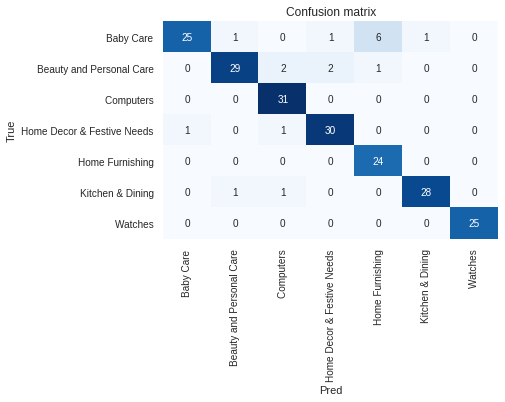

In [214]:
createConfusionMatrix(y_test,tf_predicted)

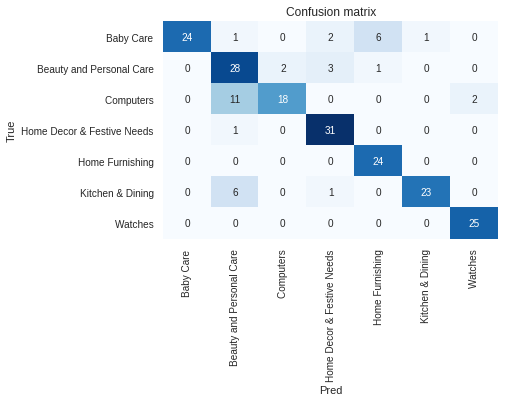

In [215]:
createConfusionMatrix(y_test,bow_predicted)

### Modèles non-supervisés

In [216]:
dataReduced = dataMini[['main_cat','use_cluster','cluster_tfidf_kmeans','cluster_bow_kmeans','w2v_cluster']]
dataReduced

,main_cat,use_cluster,cluster_tfidf_kmeans,cluster_bow_kmeans,w2v_cluster
0,Home Furnishing,5,1,2,3
1,Baby Care,5,1,2,4
2,Baby Care,5,1,2,3
3,Home Furnishing,5,1,2,3
4,Home Furnishing,5,1,2,3
...,...,...,...,...,...
1045,Baby Care,5,1,2,3
1046,Baby Care,5,1,2,2
1047,Baby Care,6,5,0,1
1048,Baby Care,6,5,0,1


In [217]:
def predict_category(data, features_extrater):
    
    #Keep only the cluster of the required extrater
    tmp_data = dataReduced[[ 'main_cat',features_extrater]]    
    
    #Handle the categorical features
    dummy = pd.get_dummies(tmp_data['main_cat'])
    tmp_data = pd.concat([tmp_data,dummy],axis= 1)
    tmp_data.drop('main_cat',axis = 1 , inplace = True)
    
    #count the prediction of each category
    confusion_matrix = tmp_data.groupby([features_extrater]).sum()

    #indexing
    confusion_matrix['cluster_number'] = confusion_matrix.index;

    #remove defalut index
    confusion_matrix.reset_index(drop=True,inplace = True)
    return confusion_matrix

In [218]:
#Calculate the prediction cluster per cateogry and select the category the most predicted
tf_prediction = predict_category(dataReduced,'cluster_tfidf_kmeans')
tf_prediction['the_most_predicted_category'] = tf_prediction.idxmax(axis=1)
tf_prediction

,Baby Care,Beauty and Personal Care,Computers,Home Decor & Festive Needs,Home Furnishing,Kitchen & Dining,Watches,cluster_number,the_most_predicted_category
0,0,0,0,0,0,0,136,0,Watches
1,37,49,58,74,76,51,14,1,Home Furnishing
2,20,0,0,0,74,1,0,2,Home Furnishing
3,0,80,68,0,0,2,0,3,Beauty and Personal Care
4,0,0,0,0,0,49,0,4,Kitchen & Dining
5,14,21,24,76,0,47,0,5,Home Decor & Festive Needs
6,79,0,0,0,0,0,0,6,Baby Care


In [219]:
use_prediction = predict_category(dataReduced,'use_cluster')
use_prediction['the_most_predicted_category'] = use_prediction.idxmax(axis=1)

In [220]:
bow_prediction = predict_category(dataReduced,'cluster_bow_kmeans')
bow_prediction['the_most_predicted_category'] = bow_prediction.idxmax(axis=1)

In [221]:
w2v_prediction = predict_category(dataReduced,'w2v_cluster')
w2v_prediction['the_most_predicted_category'] = w2v_prediction.idxmax(axis=1)

Nous allons remplacer le numéro de cluster par le nom de catégorie le plus prédit.

In [222]:
def name_predicted_category(source_data,prediction_data,merge_column):
    ''' 
    Replace predicted category number by the name of the most predicted category
    prediction_data : the prediction data set
    source_data : the origin data set
    merge_column : the column on data set on which merge will be done
    '''
    # merge target data set and source data set
    source_data = pd.merge(source_data,prediction_data[['cluster_number','the_most_predicted_category']],
                       how='left',left_on = merge_column,right_on = 'cluster_number')
    
    #Replace predicted category number by the name of the most predicted category
    source_data[[merge_column]] = source_data[['the_most_predicted_category']]

    #Drop unnecessary merge columns
    source_data.drop(columns=['the_most_predicted_category'],inplace = True)
    source_data.drop(columns=['cluster_number'],inplace = True)
    
    return source_data

In [223]:
dataReduced

,main_cat,use_cluster,cluster_tfidf_kmeans,cluster_bow_kmeans,w2v_cluster
0,Home Furnishing,5,1,2,3
1,Baby Care,5,1,2,4
2,Baby Care,5,1,2,3
3,Home Furnishing,5,1,2,3
4,Home Furnishing,5,1,2,3
...,...,...,...,...,...
1045,Baby Care,5,1,2,3
1046,Baby Care,5,1,2,2
1047,Baby Care,6,5,0,1
1048,Baby Care,6,5,0,1


In [224]:
dataReduced = name_predicted_category(dataReduced,tf_prediction,'cluster_tfidf_kmeans')
dataReduced = name_predicted_category(dataReduced,use_prediction,'use_cluster')
dataReduced = name_predicted_category(dataReduced,bow_prediction,'cluster_bow_kmeans')
dataReduced = name_predicted_category(dataReduced,w2v_prediction,'w2v_cluster')
dataReduced

,main_cat,use_cluster,cluster_tfidf_kmeans,cluster_bow_kmeans,w2v_cluster
0,Home Furnishing,Home Furnishing,Home Furnishing,Baby Care,Home Furnishing
1,Baby Care,Home Furnishing,Home Furnishing,Baby Care,Baby Care
2,Baby Care,Home Furnishing,Home Furnishing,Baby Care,Home Furnishing
3,Home Furnishing,Home Furnishing,Home Furnishing,Baby Care,Home Furnishing
4,Home Furnishing,Home Furnishing,Home Furnishing,Baby Care,Home Furnishing
...,...,...,...,...,...
1045,Baby Care,Home Furnishing,Home Furnishing,Baby Care,Home Furnishing
1046,Baby Care,Home Furnishing,Home Furnishing,Baby Care,Kitchen & Dining
1047,Baby Care,Beauty and Personal Care,Home Decor & Festive Needs,Watches,Watches
1048,Baby Care,Beauty and Personal Care,Home Decor & Festive Needs,Watches,Watches


Matrice de confusion TF-IDF et Kmeans

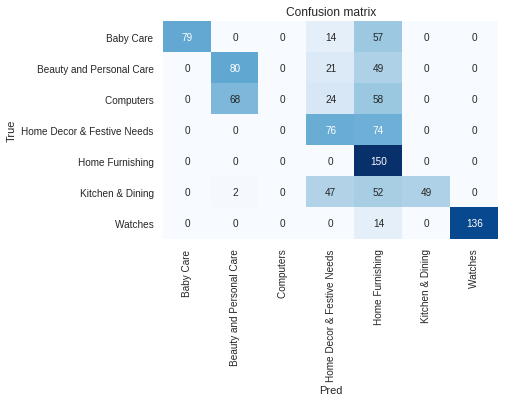

In [225]:
createConfusionMatrix(dataReduced['main_cat'],dataReduced['cluster_tfidf_kmeans'])

Matrice de confusion de bag of words et Kmeans

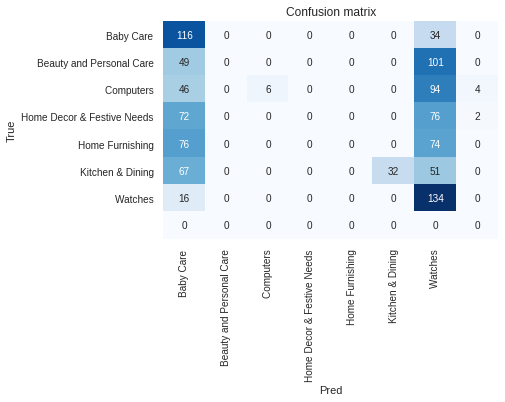

In [226]:
createConfusionMatrix(dataReduced['main_cat'],dataReduced['cluster_bow_kmeans'])

Matrice de confusion de USE et Kmeans

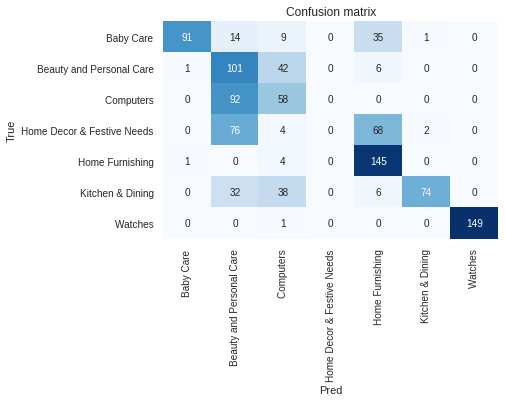

In [227]:
createConfusionMatrix(dataReduced['main_cat'],dataReduced['use_cluster'])

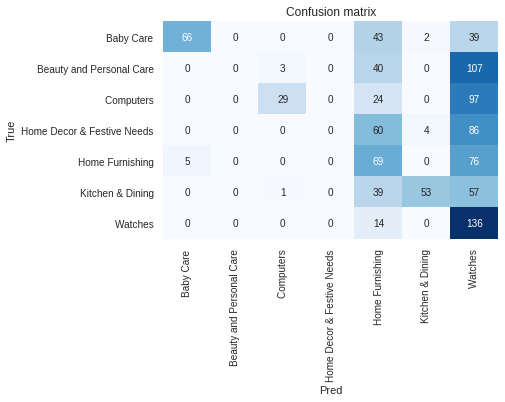

In [228]:
createConfusionMatrix(dataReduced['main_cat'],dataReduced['w2v_cluster'])

## Tableau comparatif

Nous allons créer un tableau comparatif de tous les modèles supervisés et les modèles non-supervisés


In [237]:
Columns = ['Features extractor', 'Classifier','Classifier Type','score ARI','Accuracy']
comparatif_table = pd.DataFrame(columns = Columns)

In [238]:
tf_naive_bayes = pd.DataFrame({"Features extractor":["TF-IDF"],
                    "Classifier":["Naive bayes"],
                    "Classifier Type":["Supervised"],
                    "score ARI":[adjusted_rand_score(y_test, tf_predicted)],
                    "Accuracy": [balanced_accuracy_score(y_test,tf_predicted)]})  

In [239]:
bow_naive_bayes = pd.DataFrame({"Features extractor":["Bag of words"],
                    "Classifier":["Naive bayes"],
                    "Classifier Type":["Supervised"],
                    "score ARI":[adjusted_rand_score(y_test, bow_predicted)],
                    "Accuracy": [balanced_accuracy_score(y_test,bow_predicted)]})  

In [240]:
tf_kmeans = pd.DataFrame({"Features extractor":["TF-IDF"],
                    "Classifier":["Kmeans"],
                    "Classifier Type":["Unsupervised"],
                    "score ARI":[adjusted_rand_score(dataReduced['main_cat'],dataReduced['cluster_tfidf_kmeans'])],
                    "Accuracy": [balanced_accuracy_score(dataReduced['main_cat'],dataReduced['cluster_tfidf_kmeans'])]})

In [241]:
bow_kmeans = pd.DataFrame({"Features extractor":["Bag of words"],
                    "Classifier":["Kmeans"],
                    "Classifier Type":["Unsupervised"],
                    "score ARI":[adjusted_rand_score(dataReduced['main_cat'],dataReduced['cluster_bow_kmeans'])],
                    "Accuracy": [balanced_accuracy_score(dataReduced['main_cat'],dataReduced['cluster_bow_kmeans'])]})

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


In [242]:
use_kmeans = pd.DataFrame({"Features extractor":["USE"],
                    "Classifier":["Kmeans"],
                    "Classifier Type":["Unsupervised"],
                    "score ARI":[adjusted_rand_score(dataReduced['main_cat'],dataReduced['use_cluster'])],
                    "Accuracy": [balanced_accuracy_score(dataReduced['main_cat'],dataReduced['use_cluster'])]})


In [243]:
w2v_kmeans = pd.DataFrame({"Features extractor":["W2v"],
                    "Classifier":["Kmeans"],
                    "Classifier Type":["Unsupervised"],
                    "score ARI":[adjusted_rand_score(dataReduced['main_cat'],dataReduced['w2v_cluster'])],
                    "Accuracy": [balanced_accuracy_score(dataReduced['main_cat'],dataReduced['w2v_cluster'])]})

In [249]:
result = comparatif_table.append([tf_kmeans, tf_naive_bayes,bow_kmeans,bow_naive_bayes,use_kmeans,w2v_kmeans])
result = result.sort_values(by=['Accuracy','Classifier Type'],ascending=False)
result

,Features extractor,Classifier,Classifier Type,score ARI,Accuracy
0,TF-IDF,Naive bayes,Supervised,0.807097,0.922724
0,Bag of words,Naive bayes,Supervised,0.631429,0.835068
0,USE,Kmeans,Unsupervised,0.388733,0.588571
0,TF-IDF,Kmeans,Unsupervised,0.250038,0.542857
0,W2v,Kmeans,Unsupervised,0.060773,0.336190
0,Bag of words,Kmeans,Unsupervised,0.048739,0.274286


# Sillhouette Score Analysis

In [ ]:
X= tf_vectorizer.fit_transform(dataMini['text_clean'])
X

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer

wcss = []

for i in range(2,8):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter= 300, random_state= 42)
    visualizer = SilhouetteVisualizer(kmeans)
    visualizer.fit(X)
    visualizer.show()
    wcss.append(kmeans.inertia_)   

In [ ]:
from yellowbrick.cluster import KElbowVisualizer

visualizer = KElbowVisualizer(kmeans, k=(2,10))
 
visualizer.fit(X)
visualizer.show()   

# T-SNE

In [ ]:
X = createInput(tf_vectorizer)

# Create the visualizer and draw the vectors
tsne = TSNEVisualizer()
tsne.fit(X, y_test)
tsne.show()

In [ ]:
X = createInput(bow_vectorizer)

# Create the visualizer and draw the vectors
tsne = TSNEVisualizer()
tsne.fit(X, y_test)
tsne.show()

# Test 

In [ ]:
df = dataMini[["description","main_cat"]].copy()
df.head(3)

,description,main_cat
0,Key Features of Elegance Polyester Multicolor ...,Home Furnishing
1,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care
2,Key Features of Eurospa Cotton Terry Face Towe...,Baby Care


In [ ]:
train, validation = train_test_split(df.values, test_size=0.40, random_state=23)
train = pd.DataFrame(train, columns = df.columns)
validation = pd.DataFrame(validation, columns = df.columns)

In [ ]:
train_embeddings = USE_embed(train.description)['outputs'].numpy()

kmeans = KMeans(n_clusters=7, random_state=42).fit(train_embeddings)
train.loc[:,'Clusters'] = None
train.loc[:,'Clusters'] = kmeans.labels_

display(train.sort_values(by = 'main_cat'))

,description,main_cat,Clusters
141,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,Baby Care,1
541,Buy Bestway 1.47m x 1.47m x 1.22m/Play With Su...,Baby Care,1
543,Key Features of MKB Baby Girl's Shirt Dress Ma...,Baby Care,2
228,Specifications of Cheeky Chompers The Neckerch...,Baby Care,2
482,Specifications of Thakkar Baby Girl's Printed ...,Baby Care,2
...,...,...,...
106,Maxima 17321CMLY Gold Analog Watch - For Wome...,Watches,3
295,Logues LGSWATCHES760SL Analog Watch - For Wom...,Watches,3
512,Fogg Fashion Store 3003-PK Modish Analog Watch...,Watches,3
77,HMT OLSS 01 Analog Watch - For Women - Buy HM...,Watches,3


In [ ]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(train.main_cat, kmeans.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(train.main_cat, kmeans.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(train.main_cat, kmeans.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(train.main_cat, kmeans.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(train_embeddings, train.main_cat, sample_size=1000))

display(pd.crosstab(train['Clusters'], train['main_cat']))

Homogeneity: 0.502
Completeness: 0.539
V-measure: 0.520
Adjusted Rand-Index: 0.346
Silhouette Coefficient: 0.087


main_cat,Baby Care,Beauty and Personal Care,Computers,Home Decor & Festive Needs,Home Furnishing,Kitchen & Dining,Watches
Clusters,,,,,,,
0,2,15,0,28,1,15,0
1,10,60,57,33,0,19,0
2,56,0,0,0,0,0,0
3,0,0,0,0,0,0,92
4,1,0,0,1,0,36,0
5,11,0,0,0,48,1,0
6,14,12,36,21,50,11,0


In [ ]:
def kmeans_predict(text_input, fitted_kmeans):
    tmp_embd = USE_embed([text_input])['outputs'].numpy()
    return fitted_kmeans.predict(tmp_embd)[0]

validation["Clusters"] = validation.description.apply(lambda t: kmeans_predict(text_input=t,fitted_kmeans=kmeans))
display(pd.crosstab(validation['Clusters'], validation['main_cat']))

main_cat,Baby Care,Beauty and Personal Care,Computers,Home Decor & Festive Needs,Home Furnishing,Kitchen & Dining,Watches
Clusters,,,,,,,
0,1,7,1,18,0,13,0
1,7,41,37,44,0,15,0
2,35,0,0,0,0,0,0
3,0,0,0,0,0,0,57
4,0,0,0,0,0,33,0
5,7,0,0,0,26,0,0
6,6,15,19,5,25,7,1


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from keras import backend as K

from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout, concatenate, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical
import itertools

import matplotlib.pyplot as plt

print("Tensorflow Version: ", tf.__version__)

Tensorflow Version:  2.6.0


In [ ]:
df['labels'] = df['main_cat'].map({"Home Furnishing ":0,"Baby Care ":1,"Watches ":2,"Home Decor & Festive Needs ":3,
                                   "Kitchen & Dining ":4,"Beauty and Personal Care ":5,"Computers ":6})
class_names = ['Home Furnishing ', 'Baby Care ', 'Watches ',
       'Home Decor & Festive Needs ', 'Kitchen & Dining ',
       'Beauty and Personal Care ', 'Computers ']
       
train_data = df.loc[df.labels.notnull(),:].reset_index().copy()
train_data['labels'] = train_data['labels'].astype(int)
train_data['description'] = train_data['description'].astype(str)

categorical_labels = to_categorical(train_data['labels'].values, num_classes=None)
output_size = categorical_labels.shape[1]

print('Inpus Shape: {}, Output Shape: {}'.format(train_data['description'].shape, categorical_labels.shape))

Inpus Shape: (1050,), Output Shape: (1050, 7)


In [ ]:
def build_model(embed, output_size=output_size):
    
    model = Sequential([
        Input(shape=[], dtype=tf.string),
        embed,
        Dense(output_size, activation='softmax')
    ])
    model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
model = build_model(USE_embed)
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE_embedding (KerasLayer)   {'outputs': (None, 512)}  147354880 
_________________________________________________________________
dense_11 (Dense)             (None, 7)                 3591      
Total params: 147,358,471
Trainable params: 3,591
Non-trainable params: 147,354,880
_________________________________________________________________


In [ ]:
from sklearn.model_selection import KFold

oof_preds = np.zeros([train_data.shape[0], output_size])

n_splits = 7
folds = KFold(n_splits=n_splits, shuffle=True, random_state=42)
plot_metrics = ['loss','accuracy']

Epoch 1/15
900/900 [==============================] - 123s 105ms/step - loss: 1.4940 - accuracy: 0.7622 - val_loss: 1.1718 - val_accuracy: 0.8600
Epoch 2/15
900/900 [==============================] - 79s 88ms/step - loss: 0.9090 - accuracy: 0.8878 - val_loss: 0.8137 - val_accuracy: 0.8867
Epoch 3/15
900/900 [==============================] - 80s 89ms/step - loss: 0.6421 - accuracy: 0.9044 - val_loss: 0.6277 - val_accuracy: 0.8867
Epoch 4/15
900/900 [==============================] - 81s 90ms/step - loss: 0.4960 - accuracy: 0.9122 - val_loss: 0.5177 - val_accuracy: 0.8933
Epoch 5/15
900/900 [==============================] - 80s 89ms/step - loss: 0.4048 - accuracy: 0.9178 - val_loss: 0.4436 - val_accuracy: 0.9000
Epoch 6/15
900/900 [==============================] - 80s 89ms/step - loss: 0.3429 - accuracy: 0.9278 - val_loss: 0.3959 - val_accuracy: 0.9000
Epoch 7/15
900/900 [==============================] - 79s 88ms/step - loss: 0.2978 - accuracy: 0.9389 - val_loss: 0.3597 - val_accurac

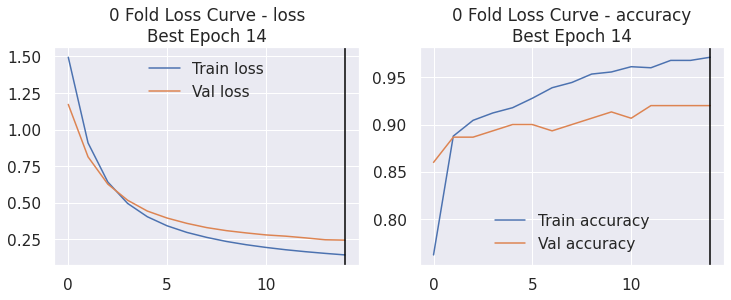

Epoch 1/15
900/900 [==============================] - 96s 91ms/step - loss: 1.4928 - accuracy: 0.7711 - val_loss: 1.1099 - val_accuracy: 0.8933
Epoch 2/15
900/900 [==============================] - 75s 83ms/step - loss: 0.9198 - accuracy: 0.8889 - val_loss: 0.7468 - val_accuracy: 0.9000
Epoch 3/15
900/900 [==============================] - 76s 84ms/step - loss: 0.6529 - accuracy: 0.8978 - val_loss: 0.5638 - val_accuracy: 0.9133
Epoch 4/15
900/900 [==============================] - 75s 83ms/step - loss: 0.5047 - accuracy: 0.9089 - val_loss: 0.4528 - val_accuracy: 0.9133
Epoch 5/15
900/900 [==============================] - 75s 84ms/step - loss: 0.4143 - accuracy: 0.9222 - val_loss: 0.3827 - val_accuracy: 0.9400
Epoch 6/15
900/900 [==============================] - 75s 84ms/step - loss: 0.3520 - accuracy: 0.9300 - val_loss: 0.3330 - val_accuracy: 0.9467
Epoch 7/15
900/900 [==============================] - 76s 85ms/step - loss: 0.3064 - accuracy: 0.9378 - val_loss: 0.2976 - val_accuracy:

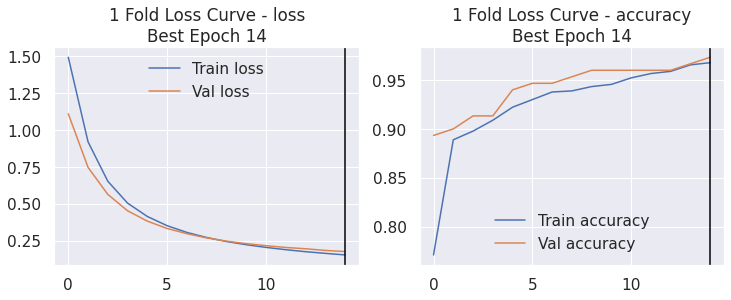

Epoch 1/15
900/900 [==============================] - 103s 97ms/step - loss: 1.5035 - accuracy: 0.7533 - val_loss: 1.0628 - val_accuracy: 0.8800
Epoch 2/15
900/900 [==============================] - 75s 84ms/step - loss: 0.9325 - accuracy: 0.8867 - val_loss: 0.6938 - val_accuracy: 0.8933
Epoch 3/15
900/900 [==============================] - 77s 85ms/step - loss: 0.6611 - accuracy: 0.9056 - val_loss: 0.5138 - val_accuracy: 0.9133
Epoch 4/15
900/900 [==============================] - 75s 84ms/step - loss: 0.5118 - accuracy: 0.9122 - val_loss: 0.4125 - val_accuracy: 0.9200
Epoch 5/15
900/900 [==============================] - 74s 82ms/step - loss: 0.4180 - accuracy: 0.9144 - val_loss: 0.3494 - val_accuracy: 0.9267
Epoch 6/15
900/900 [==============================] - 76s 84ms/step - loss: 0.3545 - accuracy: 0.9322 - val_loss: 0.3058 - val_accuracy: 0.9333
Epoch 7/15
900/900 [==============================] - 77s 86ms/step - loss: 0.3085 - accuracy: 0.9367 - val_loss: 0.2747 - val_accuracy

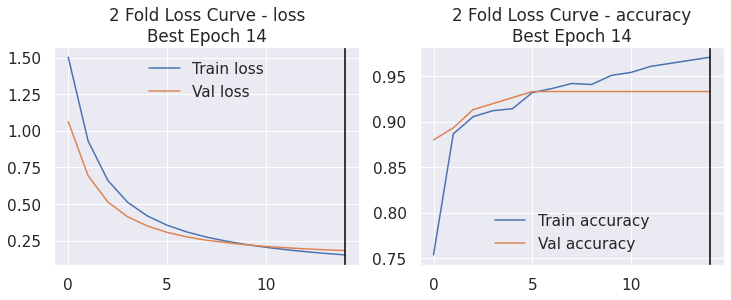

Epoch 1/15
900/900 [==============================] - 97s 95ms/step - loss: 1.4934 - accuracy: 0.7500 - val_loss: 1.1497 - val_accuracy: 0.8800
Epoch 2/15
900/900 [==============================] - 78s 87ms/step - loss: 0.9187 - accuracy: 0.8811 - val_loss: 0.7818 - val_accuracy: 0.8933
Epoch 3/15
900/900 [==============================] - 77s 86ms/step - loss: 0.6487 - accuracy: 0.8967 - val_loss: 0.6008 - val_accuracy: 0.9067
Epoch 4/15
900/900 [==============================] - 79s 88ms/step - loss: 0.5009 - accuracy: 0.9122 - val_loss: 0.4938 - val_accuracy: 0.9000
Epoch 5/15
900/900 [==============================] - 78s 87ms/step - loss: 0.4086 - accuracy: 0.9211 - val_loss: 0.4247 - val_accuracy: 0.9067
Epoch 6/15
900/900 [==============================] - 79s 88ms/step - loss: 0.3458 - accuracy: 0.9300 - val_loss: 0.3752 - val_accuracy: 0.9133
Epoch 7/15
900/900 [==============================] - 78s 86ms/step - loss: 0.3001 - accuracy: 0.9378 - val_loss: 0.3434 - val_accuracy:

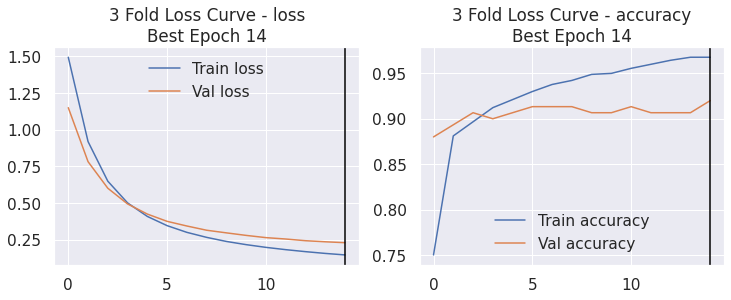

Epoch 1/15
900/900 [==============================] - 90s 88ms/step - loss: 1.4750 - accuracy: 0.7622 - val_loss: 1.1741 - val_accuracy: 0.8667
Epoch 2/15
900/900 [==============================] - 69s 76ms/step - loss: 0.9006 - accuracy: 0.8922 - val_loss: 0.8239 - val_accuracy: 0.8933
Epoch 3/15
900/900 [==============================] - 70s 77ms/step - loss: 0.6361 - accuracy: 0.9056 - val_loss: 0.6411 - val_accuracy: 0.9000
Epoch 4/15
900/900 [==============================] - 68s 76ms/step - loss: 0.4897 - accuracy: 0.9200 - val_loss: 0.5355 - val_accuracy: 0.8867
Epoch 5/15
900/900 [==============================] - 69s 77ms/step - loss: 0.3973 - accuracy: 0.9256 - val_loss: 0.4672 - val_accuracy: 0.8800
Epoch 6/15
900/900 [==============================] - 70s 77ms/step - loss: 0.3354 - accuracy: 0.9344 - val_loss: 0.4226 - val_accuracy: 0.8867
Epoch 7/15
900/900 [==============================] - 71s 79ms/step - loss: 0.2896 - accuracy: 0.9456 - val_loss: 0.3894 - val_accuracy:

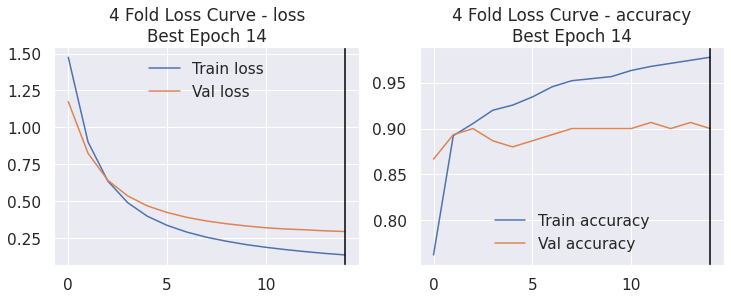

Epoch 1/15
900/900 [==============================] - 93s 92ms/step - loss: 1.4862 - accuracy: 0.7822 - val_loss: 1.1635 - val_accuracy: 0.8667
Epoch 2/15
900/900 [==============================] - 74s 82ms/step - loss: 0.9111 - accuracy: 0.8911 - val_loss: 0.8066 - val_accuracy: 0.8867
Epoch 3/15
900/900 [==============================] - 75s 83ms/step - loss: 0.6419 - accuracy: 0.9111 - val_loss: 0.6239 - val_accuracy: 0.8867
Epoch 4/15
900/900 [==============================] - 74s 82ms/step - loss: 0.4939 - accuracy: 0.9189 - val_loss: 0.5182 - val_accuracy: 0.8933
Epoch 5/15
900/900 [==============================] - 74s 83ms/step - loss: 0.4012 - accuracy: 0.9278 - val_loss: 0.4549 - val_accuracy: 0.9000
Epoch 6/15
900/900 [==============================] - 75s 83ms/step - loss: 0.3376 - accuracy: 0.9322 - val_loss: 0.4072 - val_accuracy: 0.9067
Epoch 7/15
900/900 [==============================] - 75s 83ms/step - loss: 0.2930 - accuracy: 0.9378 - val_loss: 0.3769 - val_accuracy:

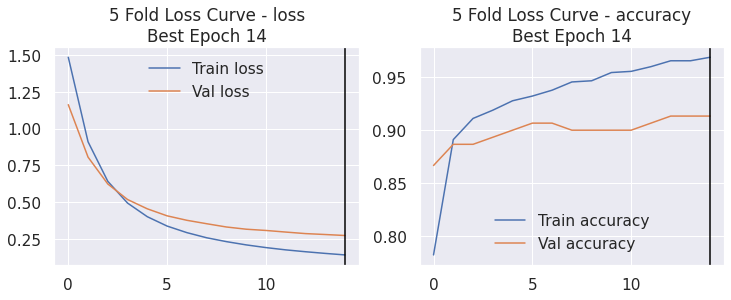

Epoch 1/15
900/900 [==============================] - 95s 94ms/step - loss: 1.5027 - accuracy: 0.7467 - val_loss: 1.1548 - val_accuracy: 0.8533
Epoch 2/15
900/900 [==============================] - 80s 89ms/step - loss: 0.9213 - accuracy: 0.8889 - val_loss: 0.7905 - val_accuracy: 0.8800
Epoch 3/15
900/900 [==============================] - 79s 88ms/step - loss: 0.6523 - accuracy: 0.9000 - val_loss: 0.6002 - val_accuracy: 0.8933
Epoch 4/15
900/900 [==============================] - 78s 87ms/step - loss: 0.5072 - accuracy: 0.9089 - val_loss: 0.4822 - val_accuracy: 0.9133
Epoch 5/15
900/900 [==============================] - 81s 91ms/step - loss: 0.4169 - accuracy: 0.9133 - val_loss: 0.4058 - val_accuracy: 0.9200
Epoch 6/15
900/900 [==============================] - 79s 88ms/step - loss: 0.3547 - accuracy: 0.9233 - val_loss: 0.3529 - val_accuracy: 0.9333
Epoch 7/15
900/900 [==============================] - 80s 89ms/step - loss: 0.3093 - accuracy: 0.9311 - val_loss: 0.3128 - val_accuracy:

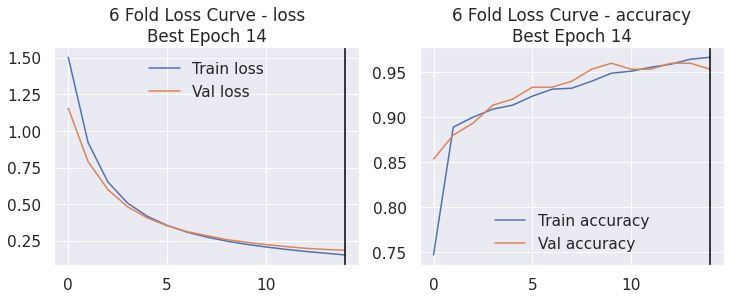

In [ ]:
import time
fold_hist = {}
for i, (trn_idx, val_idx) in enumerate(folds.split(train_data)):
    modelstart = time.time()
    model = build_model(USE_embed)
    
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=4, verbose=1,
                                 mode='min', baseline=None, restore_best_weights=True)
    
    history = model.fit(
        train_data.description[trn_idx].values,
        categorical_labels[trn_idx],
        validation_data=(
            train_data.description[val_idx].values,
            categorical_labels[val_idx]),
        epochs=15,
        batch_size=1,
        callbacks = [es],
        verbose=1)
    
    best_index = np.argmin(history.history['val_loss'])
    fold_hist[i] = history
    
    oof_preds[val_idx] = model.predict(train_data.description[val_idx].values)
    
    f, ax = plt.subplots(1,len(plot_metrics),figsize = [12,4])
    for p_i,metric in enumerate(plot_metrics):
        ax[p_i].plot(history.history[metric], label='Train ' + metric)
        ax[p_i].plot(history.history['val_' + metric], label='Val ' + metric)
        ax[p_i].set_title("{} Fold Loss Curve - {}\nBest Epoch {}".format(i, metric, best_index))
        ax[p_i].legend()
        ax[p_i].axvline(x=best_index, c='black')
    plt.show()

In [ ]:
.def plot_confusion_matrix(cm, classes,
                          title = 'Confusion matrix"',
                          cmap = plt.cm.Blues) :
    plt.figure(figsize=(15,10))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks, classes)
    plt.grid(b=None)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        plt.text(j, i, cm[i, j],
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

SyntaxError: ignored

In [ ]:
preds = oof_preds.argmax(axis = 1)
print("Accuracy: {:.2f}".format(metrics.accuracy_score(train_data['labels'], preds)))

print("Confusion Matrix")
plot_confusion_matrix(metrics.confusion_matrix(train_data['labels'], preds),
                          class_names,
                          title = 'Confusion matrix"',
                          cmap = plt.cm.Blues)

In [ ]:
import seaborn as sn

# sn.set(font_scale=1.4) # for label size
plt.figure(figsize=(10,7))
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation = 90)
plt.yticks(tick_marks, class_names)

# thresh = metrics.confusion_matrix(train_data['labels'], preds).max() / 2.
# for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
#     plt.text(j, i, cm[i, j],
#               horizontalalignment = 'center',
                #  color = 'white' if cm[i, j] > thresh else 'black')
sn.heatmap(metrics.confusion_matrix(train_data['labels'], preds), annot=True,cmap="Blues") # font size
plt.show()